In [1]:
import sys
sys.path.insert(0, '/home/student.unimelb.edu.au/shorte1/Documents/TINT')

import sys
sys.path.insert(0, '/home/563/esh563/TINT')

# Core
import datetime
import os
import glob
import tempfile
import pickle
import copy

# Analysis
import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams

# Debugging
import pdb, traceback
# %load_ext line_profiler

# Radar Tools
import pyart
import tint
# import tint.animate
# from tint.visualisation import animate

import CPOL_func as cf
import classification as cl
import caine_func as caf
import analysis

# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport CPOL_func
%aimport caine_func
%aimport classification
%aimport tint.visualisation.figures
%aimport tint.visualisation.animate
%aimport tint.visualisation.horizontal_helpers
%aimport tint.visualisation.vertical_helpers
%aimport tint.tracks
%aimport tint.objects
%aimport tint.grid_utils
%aimport tint.steiner
%aimport tint.matching
%aimport tint.rain
%aimport tint.cells
%aimport tint.tracks_helpers
%aimport tint.process_ERA5
%aimport tint.process_WRF

%pdb


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/graphml.py:346: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (np.int, "int"), (np.int8, "int"),
/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/gexf.py:220: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to us

Automatic pdb calling has been turned ON


In [21]:
base_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/CPOL/'
save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/ACCESS_radar_base/'
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/'
ERA5_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/era5/'
ERA5_dir += 'pressure-levels/reanalysis/'
WRF_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/caine_WRF_data/'

In [16]:
base_dir = '/g/data/hj10/cpol/cpol_level_1b/v2020/gridded/grid_150km_2500m/'
save_dir = '/home/563/esh563/TINT_tracks/'
fig_dir = '/home/563/esh563/TINT_figures/'
ERA5_dir = '/g/data/rt52/era5/pressure-levels/reanalysis/'

In [22]:
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Liberation Serif'})
rcParams.update({'mathtext.fontset': 'dejavuserif'})
rcParams.update({'font.size': 12})

# Boring Stats

# Load Tracks

In [29]:
class_thresh_base = {
    'OFFSET_MAG': 10000,  # metres
    'SHEAR_MAG': 2,  # m/s
    'VEL_MAG': 5,  # m/s
    'REL_VEL_MAG': 2,  # m/s
    'ANGLE_BUFFER': 10}

excl_thresh_base = {
    'SMALL_AREA': 500,  # km^2
    'LARGE_AREA': 50000,  # km^2
    'BORD_THRESH': 0.001,  # Ratio border pixels to total pixels
    'MAJOR_AXIS_LENGTH': 25,  # km
    'AXIS_RATIO': 2,
    'DURATION': 30}  # minutes

test_names = [
    'ACCESS_63', 'ACCESS_77', 'ACCESS_42']

sub_dir = save_dir.split('/')[-2]

tracks_dir = [
    sub_dir + '/ACCESS_63', 
    sub_dir + '/ACCESS_77', 
    sub_dir + '/ACCESS_42']

class_threshes = [
    None, None, None]

excl_threshes = [
    None, None, None]

non_linear_conds = [
    False, False, False]

# get_exclusions = [
#     False, False, False, False, False, False, True, True,
#     True, True, True, True, True, True, False]

# for i in range(0, len(test_names)):
for i in range(len(tracks_dir)):
    
    print('Getting classes for test:{}.'.format(test_names[i]))
    class_df = cl.get_counts(
        base_dir='/home/student.unimelb.edu.au/shorte1/Documents/CPOL_analysis/',
        tracks_dir=tracks_dir[i], 
        class_thresh=class_threshes[i], excl_thresh=excl_threshes[i],
        non_linear=non_linear_conds[i], years=[2020, 2021], fake_pope=True)

    out_file_name = save_dir + '{}_classes.pkl'.format(test_names[i])
    with open(out_file_name, 'wb') as f:
        pickle.dump(class_df, f)

Getting classes for test:ACCESS_63.
Processing year 2020
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for test:ACCESS_77.
Processing year 2020
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for test:ACCESS_42.
Processing year 2020
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.


In [35]:
class_thresh_base = {
    'OFFSET_MAG': 10000,  # metres
    'SHEAR_MAG': 2,  # m/s
    'VEL_MAG': 5,  # m/s
    'REL_VEL_MAG': 2,  # m/s
    'ANGLE_BUFFER': 10}

excl_thresh_base = {
    'SMALL_AREA': 500,  # km^2
    'LARGE_AREA': 50000,  # km^2
    'BORD_THRESH': 0.001,  # Ratio border pixels to total pixels
    'MAJOR_AXIS_LENGTH': 25,  # km
    'AXIS_RATIO': 2,
    'DURATION': 30}  # minutes

test_names = [
    'radar_63', 'radar_77', 'radar_42']

sub_dir = save_dir.split('/')[-2]

tracks_dir = [
    sub_dir + '/radar_63', 
    sub_dir + '/radar_77', 
    sub_dir + '/radar_42']

radar = [63, 77, 42]

class_threshes = [
    None, None, None]


excl_threshes = [
    None, None, None]

non_linear_conds = [
    False, False, False]

# get_exclusions = [
#     False, False, False, False, False, False, True, True,
#     True, True, True, True, True, True, False]

for i in range(len(test_names)):
# for i in range(len(tracks_dir)):
    
    print('Getting classes for test:{}.'.format(test_names[i]))
    class_df = cl.get_counts_radar(
        base_dir='/home/student.unimelb.edu.au/shorte1/Documents/CPOL_analysis/',
        tracks_dir=tracks_dir[i], 
        class_thresh=class_threshes[i], excl_thresh=excl_threshes[i],
        non_linear=non_linear_conds[i], years=[2020, 2021], radar=radar[i])

    out_file_name = save_dir + '{}_classes.pkl'.format(test_names[i])
    with open(out_file_name, 'wb') as f:
        pickle.dump(class_df, f)

Getting classes for test:radar_63.
Processing year 2020, month 10, radar, 63
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 11, radar, 63
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 12, radar, 63
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 1, radar, 63
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 2, radar, 63
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 3, radar, 63
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 4, radar, 63
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 10, radar, 63
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
P

In [36]:
radar = [63, 42, 77]
classes = []
for r in radar:
    fn = save_dir + 'ACCESS_{}_classes.pkl'.format(r)
    with open(fn, 'rb') as f:
        df = pickle.load(f)
    df = pd.concat({r: df}, names=['radar'])
    classes.append(df)

combined_classes = pd.concat(classes)
out_fn = save_dir + 'combined_ACCESS_classes.pkl'
with open(out_fn, 'wb') as f:
    pickle.dump(combined_classes, f)
    
radar = [63, 42, 77]
classes = []
for r in radar:
    fn = save_dir + 'radar_{}_classes.pkl'.format(r)
    with open(fn, 'rb') as f:
        df = pickle.load(f)
    df = pd.concat({r: df}, names=['radar'])
    classes.append(df)

combined_classes = pd.concat(classes)
out_fn = save_dir + 'combined_radar_classes.pkl'
with open(out_fn, 'wb') as f:
    pickle.dump(combined_classes, f)

In [54]:
sen_dfs = cl.plot_all(
    test_names=['combined_ACCESS', 'combined_radar'], 
    test_dir=[
        sub_dir + '/combined_ACCESS', 
        sub_dir + '/combined_radar'], diurnal=True)

In [27]:
cl.plot_comparison()

In [11]:
base_dir = '/home/student.unimelb.edu.au/shorte1/Documents/'
class_path = base_dir + 'TINT_tracks/'
class_path += 'base_classes.pkl'

with open(class_path, 'rb') as f:
    class_df = pickle.load(f)

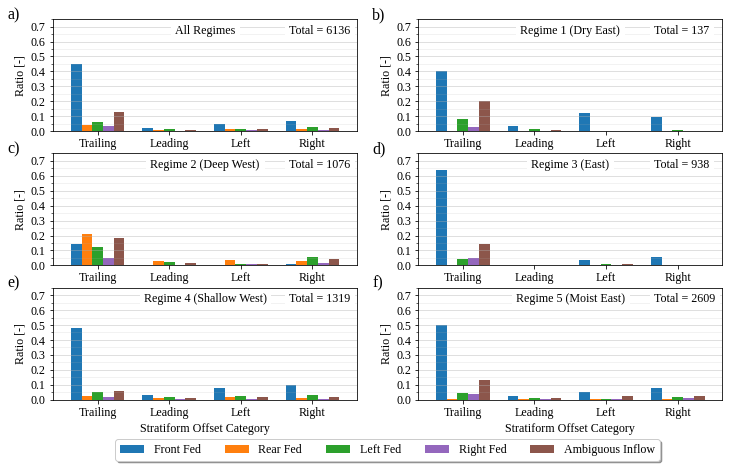

In [29]:
test_names = [
    'base', 'lower_conv_level', 'higher_conv_level', 'two_levels', 
    'four_levels', 'no_steiner', 'lower_ref_thresh', 
    'higher_shear_thresh', 'higher_rel_vel_thresh', 
    'higher_theta_e', 'higher_offset_thresh', 'higher_border_thresh',
    'higher_area_thresh', 'linear_50', 'linear_25', 'combined']

# for i in range(len(test_names)):
for i in [3]:

    base_dir = '/home/student.unimelb.edu.au/shorte1/Documents/'
    class_path = base_dir + 'TINT_tracks/'
    class_path += '{}_classes.pkl'.format(test_names[i])

    with open(class_path, 'rb') as f:
        class_df = pickle.load(f)

    cl.pope_comparison(class_df=class_df)
    
    fn = 'pope_breakdown_{}.png'.format(test_names[i])
    plt.savefig(
        fig_dir + fn, dpi=200, facecolor='w',
        edgecolor='white', bbox_inches='tight')

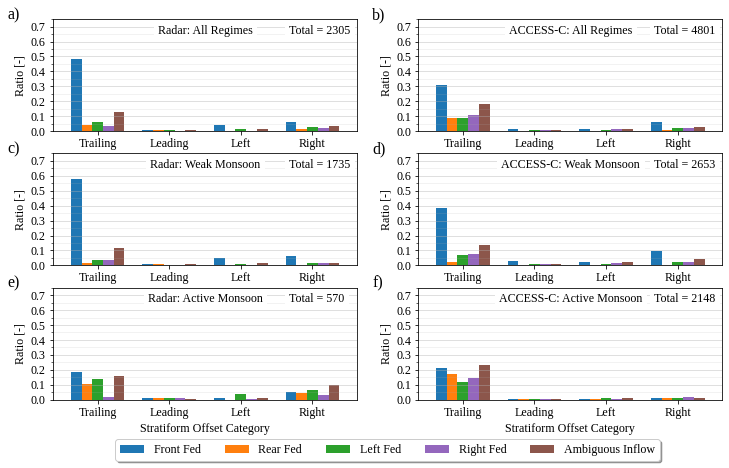

In [78]:
cl.pope_comparison_radar(class_path=save_dir)

In [25]:
base_dir = '/home/student.unimelb.edu.au/shorte1/Documents/'
class_path = base_dir + 'TINT_tracks/'
class_path += 'ACCESS_63/20201001_20210501.pkl'

with open(class_path, 'rb') as f:
    tracks = pickle.load(f)

In [17]:
base_dir = '/home/student.unimelb.edu.au/shorte1/Documents/'
class_path = base_dir + 'TINT_tracks/'
class_path += 'combined_ACCESS_classes.pkl'

with open(class_path, 'rb') as f:
    class_df = pickle.load(f)

In [20]:
counts_df = pd.DataFrame({'count': class_df.value_counts()})
counts_df = counts_df.reset_index('pope_regime')

pope = counts_df['pope_regime'].values
pope_dic = {0: 'Not Classified'}
for i in range(1, 6):
    pope_dic[i] = 'Inactive Monsoon'
pope_dic[2] = 'Active Monsoon'
monsoon = [pope_dic[p_num] for p_num in pope]
counts_df['pope_regime'] = monsoon

counts_df = counts_df[counts_df['pope_regime'] == 'Inactive Monsoon']
# counts_df = counts_df[counts_df['offset_type'] == 'Trailing Stratiform']

counts_df = counts_df.groupby(
    ['offset_type', 'inflow_type', 'tilt_dir', 'prop_dir']).sum()

counts_df = counts_df.drop('Ambiguous', level='inflow_type')
counts_df = counts_df.drop('Perpendicular Shear', level='tilt_dir')
counts_df = counts_df.drop('Ambiguous', level='tilt_dir')
counts_df = counts_df.drop('Perpendicular Shear', level='prop_dir')
counts_df = counts_df.drop('Ambiguous', level='prop_dir')

total_ratio = (counts_df['count']/counts_df['count'].sum())
counts_df['total_ratio'] = total_ratio

In [21]:
counts_df.sort_values('count', axis=0, ascending=False)

count  \
offset_type                 inflow_type          tilt_dir          prop_dir                        
Trailing Stratiform         Front Fed            Up-Shear Tilted   Down-Shear Propagating    289   
                                                 Down-Shear Tilted Up-Shear Propagating       95   
Leading Stratiform          Front Fed            Down-Shear Tilted Down-Shear Propagating     27   
Parallel Stratiform (Left)  Parallel Fed (Right) Down-Shear Tilted Up-Shear Propagating       16   
Trailing Stratiform         Parallel Fed (Left)  Up-Shear Tilted   Up-Shear Propagating       11   
Parallel Stratiform (Right) Front Fed            Up-Shear Tilted   Down-Shear Propagating      6   
Trailing Stratiform         Rear Fed             Up-Shear Tilted   Up-Shear Propagating        6   
Parallel Stratiform (Right) Parallel Fed (Right) Up-Shear Tilted   Up-Shear Propagating        5   
Trailing Stratiform         Parallel Fed (Left)  Up-Shear Tilted   Down-Shear Propagating      5   
                            Parallel Fed (Right) Down-Shear Tilted Up-Shear Propagating        5   
Parallel Stratiform (Right) Parallel Fed (Right) Down-Shear Tilted Down-Shear Propagating      4   
Leading Stratiform          Parallel Fed (Left)  Down-Shear Tilted Down-Shear Propagating      3   
Trailing Stratiform         Parallel Fed (Right) Up-Shear Tilted   Up-Shear Propagating        3   
Parallel Stratiform (Right) Rear Fed             Up-Shear Tilted   Up-Shear Propagating        3   
                            Parallel Fed (Left)  Up-Shear Tilted   Down-Shear Propagating      1   
                            Front Fed            Down-Shear Tilted Up-Shear Propagating        1   
Parallel Stratiform (Left)  Rear Fed             Down-Shear Tilted Down-Shear Propagating      1   
Trailing Stratiform         Parallel Fed (Left)  Down-Shear Tilted Down-Shear Propagating      1   
Parallel Stratiform (Left)  Front Fed            Down-Shear Tilted Down-Shear Propagating      1   
Trailing Stratiform         Parallel Fed (Right) Up-Shear Tilted   Down-Shear Propagating      1   

                                                                                           total_ratio  
offset_type                 inflow_type          tilt_dir          prop_dir                             
Trailing Stratiform         Front Fed            Up-Shear Tilted   Down-Shear Propagating     0.597107  
                                                 Down-Shear Tilted Up-Shear Propagating       0.196281  
Leading Stratiform          Front Fed            Down-Shear Tilted Down-Shear Propagating     0.055785  
Parallel Stratiform (Left)  Parallel Fed (Right) Down-Shear Tilted Up-Shear Propagating       0.033058  
Trailing Stratiform         Parallel Fed (Left)  Up-Shear Tilted   Up-Shear Propagating       0.022727  
Parallel Stratiform (Right) Front Fed            Up-Shear Tilted   Down-Shear Propagating     0.012397  
Trailing Stratiform         Rear Fed             Up-Shear Tilted   Up-Shear Propagating       0.012397  
Parallel Stratiform (Right) Parallel Fed (Right) Up-Shear Tilted   Up-Shear Propagating       0.010331  
Trailing Stratiform         Parallel Fed (Left)  Up-Shear Tilted   Down-Shear Propagating     0.010331  
                            Parallel Fed (Right) Down-Shear Tilted Up-Shear Propagating       0.010331  
Parallel Stratiform (Right) Parallel Fed (Right) Down-Shear Tilted Down-Shear Propagating     0.008264  
Leading Stratiform          Parallel Fed (Left)  Down-Shear Tilted Down-Shear Propagating     0.006198  
Trailing Stratiform         Parallel Fed (Right) Up-Shear Tilted   Up-Shear Propagating       0.006198  
Parallel Stratiform (Right) Rear Fed             Up-Shear Tilted   Up-Shear Propagating       0.006198  
                            Parallel Fed (Left)  Up-Shear Tilted   Down-Shear Propagating     0.002066  
                            Front Fed            Down-Shear Tilted Up-Shear Propagating       0.002066  


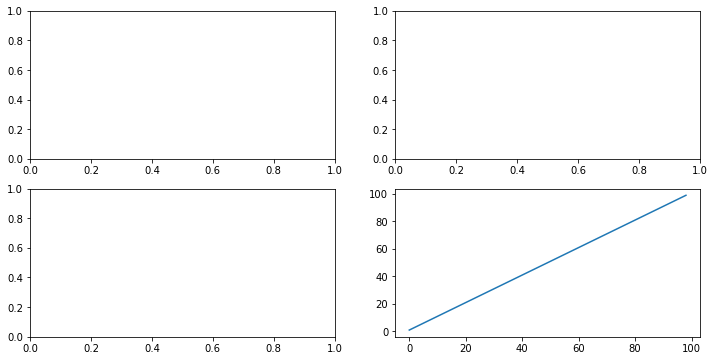

In [10]:
fig, axes = plt.subplots(
    int(np.ceil(len([1,2,3,4])/2)), 2, figsize=(12, 6))
axes.flatten()[3].plot(np.arange(1,100))

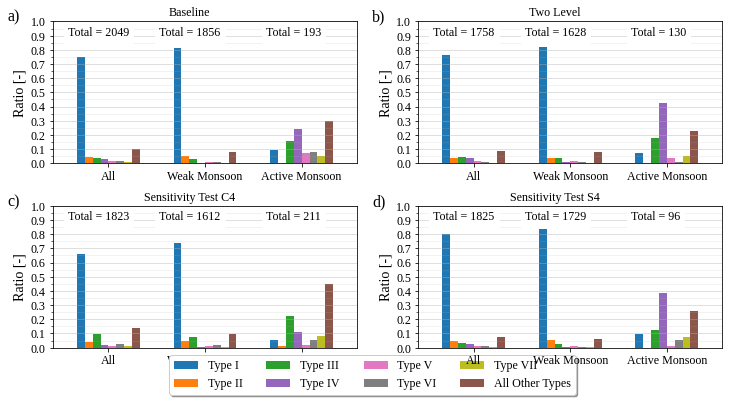

In [13]:
test_names = [
    'base', 'lower_conv_level', 'higher_conv_level', 'two_levels', 
    'four_levels',
    'no_steiner', 'lower_ref_thresh', 'higher_shear_thresh', 
    'higher_rel_vel_thresh', 
    'higher_theta_e', 'higher_offset_thresh', 'higher_border_thresh',
    'higher_area_thresh', 'linear_50', 'linear_25', 'combined']

# test_names = [
#     'base', 'lower_conv_level', 
#     'higher_conv_level', 'higher_shear_thresh']

# titles = [
#     'Baseline', 'Sensitivity Test C2', 'Sensitivity Test C4',
#     'Sensitivity Test S4']

test_names = [
    'base', 'two_levels', 
    'higher_conv_level', 'higher_shear_thresh']

titles = [
    'Baseline', 'Two Level',
    'Sensitivity Test C4',
    'Sensitivity Test S4']

fig, axes = plt.subplots(
    int(np.ceil(len(test_names)/2)), 2, figsize=(12, 6))

for i in range(len(test_names)):
# for i in [3]:

    base_dir = '/home/student.unimelb.edu.au/shorte1/Documents/'
    class_path = base_dir + 'TINT_tracks/'
    class_path += '{}_classes.pkl'.format(test_names[i])

    with open(class_path, 'rb') as f:
        class_df = pickle.load(f)

    ratios_df = cl.monsoon_comparison(
        class_df, fig=fig, ax=axes.flatten()[i], legend=False, 
        title=titles[i])
            
#     fn = 'shear_breakdown_{}.png'.format(test_names[i])
#     plt.savefig(
#         fig_dir + fn, dpi=200, facecolor='w',
#         edgecolor='white', bbox_inches='tight')

axes.flatten()[-2].legend(
    loc='lower center', bbox_to_anchor=(1.05, -0.375),
    ncol=4, fancybox=True, shadow=True)

cl.make_subplot_labels(axes.flatten())

plt.subplots_adjust(hspace=0.3)

fn = 'monsoon_breakdown_base_lower_higher_lvl_higher_shear_two_level.png'.format(test_names[i])
plt.savefig(
    fig_dir + fn, dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')

No unclassified regime cases.
No unclassified regime cases.


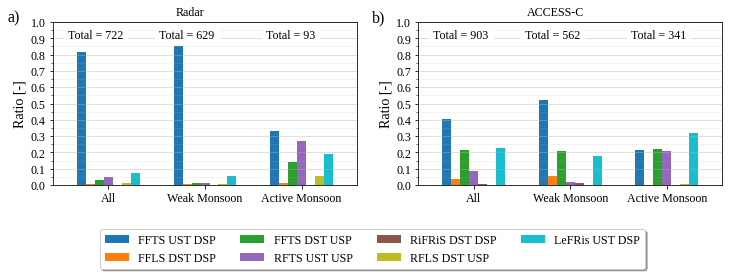

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

base_dir = '/home/student.unimelb.edu.au/shorte1/Documents/'
class_path = base_dir + 'TINT_tracks/ACCESS_radar_ambient_swapped/'
class_path += 'combined_radar_classes.pkl'

with open(class_path, 'rb') as f:
    class_df = pickle.load(f)
    
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors = [colors[i] for i in [0, 1, 2, 4, 5, 8, 9]]
    
required_types = [
    (
        'Trailing Stratiform', 'Front Fed',
        'Up-Shear Tilted', 'Down-Shear Propagating'),
    (
        'Leading Stratiform', 'Front Fed',
        'Down-Shear Tilted', 'Down-Shear Propagating'),
    (
        'Trailing Stratiform', 'Front Fed',
        'Down-Shear Tilted', 'Up-Shear Propagating'),
    (
        'Trailing Stratiform', 'Rear Fed',
        'Up-Shear Tilted', 'Up-Shear Propagating'),
    (
        'Parallel Stratiform (Right)', 'Parallel Fed (Right)',
        'Down-Shear Tilted', 'Down-Shear Propagating'),
    (
        'Leading Stratiform', 'Rear Fed',
        'Down-Shear Tilted', 'Up-Shear Propagating'),
    (
        'Parallel Stratiform (Right)', 'Parallel Fed (Left)',
        'Up-Shear Tilted', 'Down-Shear Propagating'),
    ]
titles = [
    'FFTS UST DSP', 'FFLS DST DSP', 'FFTS DST USP', 
    'RFTS UST USP', 'RiFRiS DST DSP', 'RFLS DST USP', 'LeFRis UST DSP']

# required_types = [
# ]
# titles = [
#     'FFTS UST DSP', 'FFLS DST DSP', 'FFTS DST USP',
#     'RFTS UST USP']

ratios_df = cl.monsoon_comparison(
    class_df, fig=fig, ax=axes[0], legend=False, 
    title='Radar', required_types=required_types, titles=titles, 
    colors=colors)

base_dir = '/home/student.unimelb.edu.au/shorte1/Documents/'
class_path = base_dir + 'TINT_tracks/ACCESS_radar_ambient_swapped/'
class_path += 'combined_ACCESS_classes.pkl'

with open(class_path, 'rb') as f:
    class_df = pickle.load(f)
    
# required_types = [
#     (
#         'Trailing Stratiform', 'Front Fed',
#         'Up-Shear Tilted', 'Down-Shear Propagating'),
#     (
#         'Trailing Stratiform', 'Front Fed',
#         'Down-Shear Tilted', 'Up-Shear Propagating'),
#     (
#         'Trailing Stratiform', 'Rear Fed',
#         'Up-Shear Tilted', 'Up-Shear Propagating'),
#     (
#         'Leading Stratiform', 'Front Fed',
#         'Down-Shear Tilted', 'Down-Shear Propagating'),
#     ]
# titles = [
#     'FFTS UST DSP', 'FFTS DST USP', 'RFTS UST USP', 'FFLS DST DSP']

ratios_df = cl.monsoon_comparison(
    class_df, fig=fig, ax=axes[1], legend=False,
    title='ACCESS-C', required_types=required_types, titles=titles,
    colors=colors)
            
#     fn = 'shear_breakdown_{}.png'.format(test_names[i])
#     plt.savefig(
#         fig_dir + fn, dpi=200, facecolor='w',
#         edgecolor='white', bbox_inches='tight')

axes[0].legend(
    loc='lower center', bbox_to_anchor=(1.05, -0.55),
    ncol=4, fancybox=True, shadow=True)

cl.make_subplot_labels(axes.flatten())

# plt.subplots_adjust(hspace=0.3)

fn = 'monsoon_breakdown_radar.png'
plt.savefig(
    fig_dir + fn, dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')

# Calculate Some Statistics

In [295]:
offset_sensitivity_df = pd.DataFrame({
    'Test': test, 'Trailing Stratiform': TS, 
    'Leading Stratiform': LS, 'Parallel Stratiform (Left)': LeS,
    'Parallel Stratiform (Right)': RiS, 'Total': total})

## System Size

In [260]:
[t/totals[-1]*100 for t in totals]

[counts    70.297463
 dtype: float64,
 counts    5.708661
 dtype: float64,
 counts    8.420822
 dtype: float64,
 counts    15.573053
 dtype: float64,
 counts    100.0
 dtype: float64]

In [301]:
inflow_sensitivity_df

,Test,Front Fed,Rear Fed,Parallel Fed (Left),Parallel Fed (Right),Ambiguous,Total
0,Base,2661,350,536,235,790,4572


In [7]:
# subset_logic = ~small_area
# sub_tracks = tracks_obj.system_tracks[subset_logic]
sub_tracks = tracks_obj.system_tracks

sub_uids = list(sorted(set([int(sub_tracks.index.values[i][2]) for i in range(len(sub_tracks))])))
sub_uids = [str(i) for i in sub_uids]

# MCS_lengths = [len(sub_tracks.xs(i, level='uid').reset_index(level='time').index.values) for i in sub_uids]
# max_MCS = max(MCS_lengths)

In [287]:
sensitivity_df.set_index('Test')

,Trailing Stratiform,Leading Stratiform,Parallel Stratiform (Left),Parallel Stratiform (Right),Total
Test,,,,,
Base,3214,261,385,712,4572


In [264]:
[t/totals[-1]*100 for t in totals]

[counts    70.297463
 dtype: float64,
 counts    5.708661
 dtype: float64,
 counts    8.420822
 dtype: float64,
 counts    15.573053
 dtype: float64,
 counts    100.0
 dtype: float64]

In [14]:
# Create 3 lists with lengths the lifetime of longest object.
[large, small, medium, nb, totals] = [np.zeros(100) for i in range(5)]

from tqdm import tqdm

for i in tqdm(sub_uids, file=sys.stdout, position=0, leave=True):
    
#     import pdb
#     pdb.set_trace()
    
    obj = sub_tracks.xs(i, level='uid').reset_index(level='time')
    cat = categories.xs(i, level='uid').reset_index(level='time')
    scans = obj.index.values
    scan_label = scans - min(scans)
    
    # Define classifications
    large_area = cat['large_area'].values
    small_area = cat['small_area'].values
    medium_area = ~large_area & ~small_area
    not_border = cat['not_border'].values | cat['not_border_0'].values
    
    large_inds = scan_label[large_area]
    medium_inds = scan_label[medium_area]
    small_inds = scan_label[small_area]
    not_border_inds = scan_label[not_border]
    totals_inds = scan_label.tolist()
    
    # Break down sig_tilt categories
#     forward_tilt = ((-45 <= tilts) & (tilts <= 45)) 
#     backward_tilt = ((-135 >= tilts) | (tilts >= 135)) 

#     fwd_inds = scan_label[np.argwhere(forward_tilt).flatten().tolist()].tolist()
#     bwd_inds = scan_label[np.argwhere(backward_tilt).flatten().tolist()].tolist()
#     pll_inds = scan_label[np.argwhere(~backward_tilt & ~forward_tilt).flatten().tolist()].tolist()

    # Found error with large com dataset - object 14060 jumps across seasons
    try:
        large[large_inds] += 1
        small[small_inds] += 1
        medium[medium_inds] += 1
        nb[not_border_inds] += 1
        totals[totals_inds] += 1
    except:
        print('Error with system {}.'.format(i))

100%|██████████| 25948/25948 [02:18<00:00, 186.83it/s]


In [298]:
inflow_sensitivity_df = pd.DataFrame({
    'Test': test, 'Front Fed': FF, 
    'Rear Fed': RF, 'Parallel Fed (Left)': LeF,
    'Parallel Fed (Right)': RiF, 'Total': total})

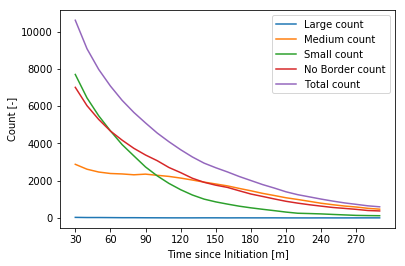

In [17]:
plt.plot(np.arange(30,300,10), large[3:30], label='Large count')
plt.plot(np.arange(30,300,10), medium[3:30], label='Medium count')
plt.plot(np.arange(30,300,10), small[3:30], label='Small count')
plt.plot(np.arange(30,300,10), nb[3:30], label='No Border count')
plt.plot(np.arange(30,300,10), totals[3:30], label='Total count')
plt.xticks(np.arange(30,300,30))
plt.ylabel('Count [-]')
plt.xlabel('Time since Initiation [m]')
plt.legend()
plt.savefig('/g/data/w40/esh563/CPOL_analysis/figures/TINT/size_counts.png')

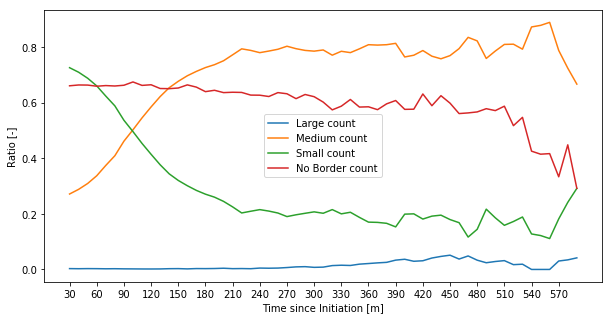

In [22]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(30,600,10), (large/totals)[3:60], label='Large count')
plt.plot(np.arange(30,600,10), (medium/totals)[3:60], label='Medium count')
plt.plot(np.arange(30,600,10), (small/totals)[3:60], label='Small count')
plt.plot(np.arange(30,600,10), (nb/totals)[3:60], label='No Border count')
plt.xticks(np.arange(30,600,30))
plt.ylabel('Ratio [-]')
plt.xlabel('Time since Initiation [m]')
plt.legend()
# Note that we don't really know the start times of the systems!
plt.savefig('/g/data/w40/esh563/CPOL_analysis/figures/TINT/size_ratios.png')

## Training Lines

In [12]:
subset_logic = (categories['not_border'] & categories['not_border_0']
                & ~categories['large_area'] & ~categories['small_area'] 
                & categories['linear'] & ~categories['stationary']
                & categories['sig_vel_mag'])
sub_tracks = tracks_obj.system_tracks[subset_logic]
sub_cat = categories[subset_logic]
# sub_tracks = tracks_obj.system_tracks
# sub_cat = categories

sub_uids = list(sorted(set([int(sub_tracks.index.values[i][2])
                            for i in range(len(sub_tracks))])))
sub_uids = [str(i) for i in sub_uids]

# MCS_lengths = [len(sub_tracks.xs(i, level='uid').reset_index(level='time').index.values) for i in sub_uids]
# max_MCS = max(MCS_lengths)

In [13]:
# Create 3 lists with lengths the lifetime of longest object.
[par, perp, totals] = [np.zeros(100) for i in range(3)]

from tqdm import tqdm

for i in tqdm(sub_uids, file=sys.stdout, position=0, leave=True):
       
    obj = sub_tracks.xs(i, level='uid').reset_index(level='time')
    cat = sub_cat.xs(i, level='uid').reset_index(level='time')
    scans = obj.index.values
    scan_label = scans - min(scans)
    
    # Define classifications
    perp_align = cat['perp_align'].values
    par_align = cat['par_align'].values
        
    par_inds = scan_label[par_align]
    perp_inds = scan_label[perp_align]
    totals_inds = scan_label.tolist()

    # Found error with large com dataset - object 14060 jumps across seasons
    try:
        par[par_inds] += 1
        perp[perp_inds] += 1
        totals[totals_inds] += 1
    except:
        print('Error with system {}.'.format(i))

100%|██████████| 91/91 [00:00<00:00, 170.20it/s]


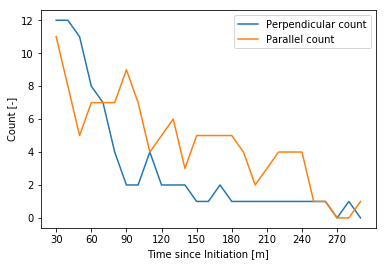

In [14]:
plt.plot(np.arange(30,300,10), perp[3:30], label='Perpendicular count')
plt.plot(np.arange(30,300,10), par[3:30], label='Parallel count')
# plt.plot(np.arange(30,300,10), totals[3:30], label='Total count')
plt.xticks(np.arange(30,300,30))
plt.ylabel('Count [-]')
plt.xlabel('Time since Initiation [m]')
plt.legend()
plt.savefig('/g/data/w40/esh563/CPOL_analysis/figures/TINT/size_counts.png')

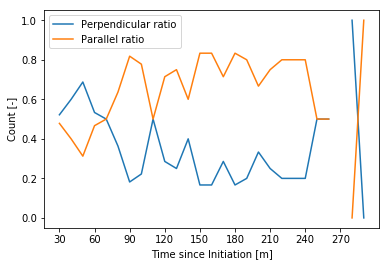

In [15]:
plt.plot(np.arange(30,300,10), (perp/totals)[3:30], label='Perpendicular ratio')
plt.plot(np.arange(30,300,10), (par/totals)[3:30], label='Parallel ratio')
plt.xticks(np.arange(30,300,30))
plt.ylabel('Count [-]')
plt.xlabel('Time since Initiation [m]')
plt.legend()
plt.savefig('/g/data/w40/esh563/CPOL_analysis/figures/TINT/size_counts.png')

## Updraft Tilt versus Stratiform Tilt

In [29]:
def calc_mean_max_updrafts(system_tracks, min_height_ind = 20):
    ud = system_tracks['updrafts']
    ud_tilt = []
    tallest_ud = []
    mean_ud = []
    no_tilt=0
    for i in range(len(ud)):
        ud_i = ud.iloc[i]
        ud_tilt_i = []
        for j in range(len(ud_i)):
            if ud_i[j][-1][0] >= min_height_ind:
                ud_tilt_i_j = (ud_i[j][-1]-ud_i[j][0])*(.5, 2.5, 2.5)
                if np.all(ud_tilt_i_j[1:3] == [0,0]):
                    # Count updrafts with no tilt seperately
                    no_tilt+=1
                else:
                    ud_tilt_i.append(ud_tilt_i_j)
       
        if ud_tilt_i != []:
            ud_tilt.append(ud_tilt_i)
            mean_ud.append(np.nanmean(np.array(ud_tilt_i), axis=0))
        else:
            ud_tilt.append(np.ones(3)*np.nan)
            mean_ud.append(np.ones(3)*np.nan)
        try:
            tallest_ind = np.argmax(np.array(ud_tilt_i)[:,0])
            tallest_ud.append(np.array(ud_tilt_i)[tallest_ind,:])
        except:
            tallest_ud.append(np.ones(3)*np.nan)
        
    return ud_tilt, mean_ud, tallest_ud

### Tallest Updraft

In [155]:
q_str = "(offset_type == 'Trailing Stratiform'"
q_str += "and inflow_type == 'Front Fed')"
q_str += "or (offset_type == 'Leading Stratiform'"
q_str += "and inflow_type == 'Rear Fed')"
q_str += "or (offset_type == 'Parallel Stratiform (Left)'"
q_str += "and inflow_type == 'Parallel Fed (Right)')"
q_str += "or (offset_type == 'Parallel Stratiform (Right)'"
q_str += "and inflow_type == 'Parallel Fed (Left)')"
TS = counts_df.query(q_str)

q_str = "(offset_type == 'Leading Stratiform'"
q_str += "and inflow_type == 'Front Fed')"
q_str += "or (offset_type == 'Trailing Stratiform'"
q_str += "and inflow_type == 'Rear Fed')"
q_str += "or (offset_type == 'Parallel Stratiform (Left)'"
q_str += "and inflow_type == 'Parallel Fed (Left)')"
q_str += "or (offset_type == 'Parallel Stratiform (Right)'"
q_str += "and inflow_type == 'Parallel Fed (Right)')"
LS = counts_df.query(q_str)

q_str = "(offset_type == 'Leading Stratiform'"
q_str += "and inflow_type == 'Parallel Fed (Right)')"
q_str += "or (offset_type == 'Trailing Stratiform'"
q_str += "and inflow_type == 'Parallel Fed (Left)')"
q_str += "or (offset_type == 'Parallel Stratiform (Left)'"
q_str += "and inflow_type == 'Front Fed')"
q_str += "or (offset_type == 'Parallel Stratiform (Right)'"
q_str += "and inflow_type == 'Rear Fed (Right)')"
LeS = counts_df.query(q_str)

q_str = "(offset_type == 'Leading Stratiform'"
q_str += "and inflow_type == 'Parallel Fed (Left)')"
q_str += "or (offset_type == 'Trailing Stratiform'"
q_str += "and inflow_type == 'Parallel Fed (Right)')"
q_str += "or (offset_type == 'Parallel Stratiform (Right)'"
q_str += "and inflow_type == 'Front Fed')"
q_str += "or (offset_type == 'Parallel Stratiform (Left)'"
q_str += "and inflow_type == 'Rear Fed')"
RiS = counts_df.query(q_str)

In [33]:
subset_logic = sig_area & not_border & sig_tilt_mag & not_border_0 & sig_vel_mag
sub_tracks = tracks_obj.system_tracks[subset_logic]
ud_tilt, mean_ud, tallest_ud = calc_mean_max_updrafts(sub_tracks)

num = np.array(tallest_ud)
den = np.tile(np.array(tallest_ud)[:,0], (3,1)).transpose()
ud_norm = (num/den)[:,1:]
ud_mag = np.sqrt(ud_norm[:,0] ** 2 + ud_norm[:,1] ** 2)
ud_dir = np.arctan2(ud_norm[:,0], ud_norm[:,1])
ud_dir = np.rad2deg(ud_dir)

vel_dir = sub_tracks['vel_dir'].values
tilt_dir = sub_tracks['tilt_dir'].values

sys_rel_tilt_dir = np.mod(tilt_dir - vel_dir, 360)
sys_rel_tilt_dir = np.round(sys_rel_tilt_dir, 3)

sys_rel_ud_tilt_dir = np.mod(ud_dir - vel_dir, 360)
sys_rel_ud_tilt_dir = np.round(sys_rel_ud_tilt_dir, 3)

In [149]:
3270.000000/(5944.000000/.80749898)

0.44423311988559894

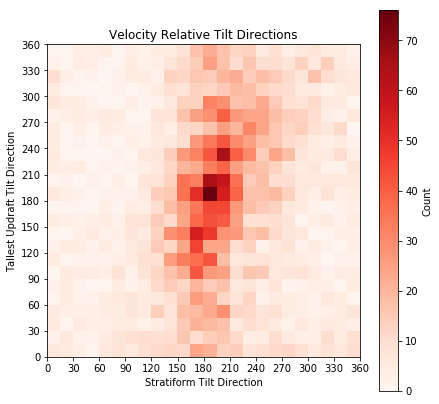

In [35]:
vel_dir = sub_tracks['vel_dir'].values
vel_mag = np.sqrt(sub_tracks['u_shift']**2 + sub_tracks['v_shift']**2).values
tilt_dir = sub_tracks['tilt_dir'].values
bins = np.arange(0,360+15,15)
ticks = np.arange(0,360+30,30)

fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111)
h = ax.hist2d(sys_rel_tilt_dir, sys_rel_ud_tilt_dir, bins=bins, range=[[0, 360], [0, 360]], cmap='Reds')
# ax.scatter(tilt_dir, ud_dir, s=0.75)
plt.xlabel('Stratiform Tilt Direction')
plt.ylabel('Tallest Updraft Tilt Direction')
plt.title('Velocity Relative Tilt Directions')
plt.xlim([0, 360])
plt.ylim([0, 360])
plt.xticks(ticks)
plt.yticks(ticks)
ax.set_aspect('equal')
cb = plt.colorbar(h[3], ax=ax)
cb.set_label('Count')

### Mean Updraft

In [36]:
subset_logic = sig_area & not_border & sig_tilt_mag & not_border_0 & sig_vel_mag
sub_tracks = tracks_obj.system_tracks[subset_logic]
ud_tilt, mean_ud, tallest_ud = calc_mean_max_updrafts(sub_tracks)

num = np.array(mean_ud)
den = np.tile(np.array(mean_ud)[:,0], (3,1)).transpose()
ud_norm = (num/den)[:,1:]
ud_mag = np.sqrt(ud_norm[:,0] ** 2 + ud_norm[:,1] ** 2)
ud_dir = np.arctan2(ud_norm[:,0], ud_norm[:,1])
ud_dir = np.rad2deg(ud_dir)

vel_dir = sub_tracks['vel_dir'].values
tilt_dir = sub_tracks['tilt_dir'].values

sys_rel_tilt_dir = np.mod(tilt_dir - vel_dir, 360)
sys_rel_tilt_dir = np.round(sys_rel_tilt_dir, 3)

sys_rel_ud_tilt_dir = np.mod(ud_dir - vel_dir, 360)
sys_rel_ud_tilt_dir = np.round(sys_rel_ud_tilt_dir, 3)

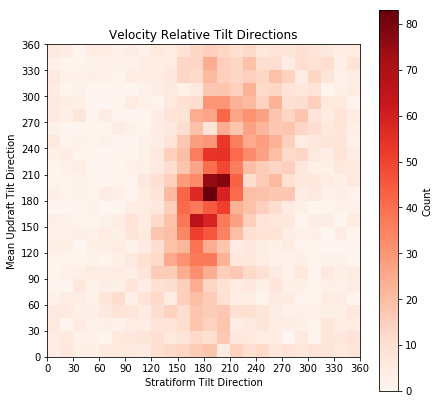

In [38]:
vel_dir = sub_tracks['vel_dir'].values
vel_mag = np.sqrt(sub_tracks['u_shift']**2 + sub_tracks['v_shift']**2).values
tilt_dir = sub_tracks['tilt_dir'].values
bins = np.arange(0,360+15,15)
ticks = np.arange(0,360+30,30)

fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111)
h = ax.hist2d(sys_rel_tilt_dir, sys_rel_ud_tilt_dir, bins=bins, range=[[0, 360], [0, 360]], cmap='Reds')
# ax.scatter(tilt_dir, ud_dir, s=0.75)
plt.xlabel('Stratiform Tilt Direction')
plt.ylabel('Mean Updraft Tilt Direction')
plt.title('Velocity Relative Tilt Directions')
plt.xlim([0, 360])
plt.ylim([0, 360])
plt.xticks(ticks)
plt.yticks(ticks)
ax.set_aspect('equal')
cb = plt.colorbar(h[3], ax=ax)
cb.set_label('Count')

In [11]:
base_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/CPOL/'
save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/'
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/'
ERA5_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/era5/'
ERA5_dir += 'pressure-levels/reanalysis/'
WRF_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/caine_WRF_data/'

## Rain

In [9]:
uids = list(set([tracks_obj.system_tracks.index[i][2] for i in range(len(tracks_obj.system_tracks))]))

ratio = []
tot_rain = []

for u in uids:
    hours = len(tracks_obj.system_tracks.xs(u, level='uid'))*1/6
    r = categories.xs(u, level='uid')['par_align'].sum()/len(tracks_obj.system_tracks.xs(u, level='uid'))
    ratio.append(r)
    tot_rain.append(tracks_obj.system_tracks.xs(u, level='uid')['tot_rain'][-1])
# tracks_obj.system_tracks.xs('0', level='uid')['vel_dir']

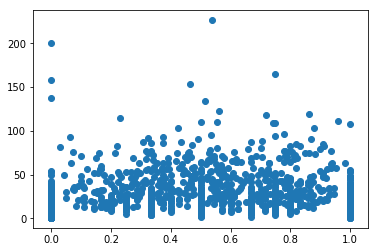

In [10]:
tot_rain = np.array(tot_rain)
tot_rain[tot_rain>500]=np.nan
plt.scatter(ratio, tot_rain)

In [73]:
sub_cat['par_align'].groupby(level='uid').sum().sort_values(ascending=False)[:20]

Series([], Name: par_align, dtype: bool)

In [ ]:
## Rain

uids = list(set([tracks_obj.system_tracks.index[i][2] for i in range(len(tracks_obj.system_tracks))]))

ratio = []
tot_rain = []

for u in uids:
    hours = len(tracks_obj.system_tracks.xs(u, level='uid'))*1/6
    r = categories.xs(u, level='uid')['par_align'].sum()/len(tracks_obj.system_tracks.xs(u, level='uid'))
    ratio.append(r)
    tot_rain.append(tracks_obj.system_tracks.xs(u, level='uid')['tot_rain'][-1])
# tracks_obj.system_tracks.xs('0', level='uid')['vel_dir']

tot_rain = np.array(tot_rain)
tot_rain[tot_rain>500]=np.nan
plt.scatter(ratio, tot_rain)

sub_cat['par_align'].groupby(level='uid').sum().sort_values(ascending=False)[:20]

In [58]:
era5_all = xr.open_dataset('/home/student.unimelb.edu.au/shorte1/Documents/era5_stuff/adaptor.mars.internal-1655899408.0752895-17633-20-091d1e31-ec26-4545-850c-8a330be7c27e.nc')

In [59]:
era5_all

<xarray.Dataset>
Dimensions:    (latitude: 43, level: 37, longitude: 53, time: 744)
Coordinates:
  * longitude  (longitude) float32 127.0 127.2 127.5 127.8 ... 139.5 139.8 140.0
  * latitude   (latitude) float32 -7.5 -7.75 -8.0 -8.25 ... -17.5 -17.75 -18.0
  * level      (level) int32 1 2 3 5 7 10 20 30 ... 850 875 900 925 950 975 1000
  * time       (time) datetime64[ns] 2022-05-01 ... 2022-05-31T23:00:00
Data variables:
    z          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-06-22 12:06:07 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...

In [62]:
era5_all.z.to_netcdf('/home/student.unimelb.edu.au/shorte1/Documents/era5_stuff/z_era5_oper_pl_20220501-20220531.nc')

In [40]:
sample = xr.open_dataset('/media/shorte1/Ewan\'s Hard Drive/phd/data/era5/pressure-levels/reanalysis/u/2005/u_era5_oper_pl_20051201-20051231.nc')

In [43]:
longitude = sample.longitude
latitude = sample.latitude
latitude

<xarray.DataArray 'latitude' (latitude: 25)>
array([ -9.  ,  -9.25,  -9.5 ,  -9.75, -10.  , -10.25, -10.5 , -10.75, -11.  ,
       -11.25, -11.5 , -11.75, -12.  , -12.25, -12.5 , -12.75, -13.  , -13.25,
       -13.5 , -13.75, -14.  , -14.25, -14.5 , -14.75, -15.  ], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 -9.0 -9.25 -9.5 -9.75 ... -14.5 -14.75 -15.0
Attributes:
    units:      degrees_north
    long_name:  latitude

In [60]:
test = sample.sel(latitude=-12.4247, longitude=130.8919, method='nearest').sel(
    level=slice(700, 1000))